In [27]:
# !pip install torch==1.4.0 torchvision==0.4.1

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import pickle as pkl
import math
from tqdm import tqdm
import copy
import time
import random

In [29]:
print(torch.__version__ )

1.8.1+cu101


In [30]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
def walk(path):
  if not os.path.exists(path):
    return -1
    for root, dirs, names in os.walk(path):
      for filename in names:
        print(os.path.join(root,filename))

In [32]:
def findNearestSmallerTime(refTime, location_msg):
  left = 0
  right = len(location_msg) - 1
  Time = location_msg["Time"]
  while left < right - 1: 
    mid = (int)(left + (right - left)/2)
    if Time.loc[mid] == refTime :
      return location_msg.loc[mid]
    elif Time.loc[mid] < refTime:
      left = mid
    else:
      right = mid - 1;
  if Time.loc[right]  < refTime:
    return location_msg.loc[right]
  else:
    return location_msg.loc[left]

In [33]:
def concatData(ctrl_msg, loc_msg):
  df = pd.DataFrame(columns=['Req_Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'])
  for idx, data in ctrl_msg.iterrows():
    # print(data['Time'])
    loc_msg_pair = findNearestSmallerTime(data['Time'], loc_msg)
    df.loc[idx] = [data['Time'], data['Acc_TarA'], data['EPSDAIReq'], loc_msg_pair['easting'], loc_msg_pair['northing'], loc_msg_pair['speed'], loc_msg_pair['yaw'], loc_msg_pair['Time']]
    # print(df.loc[idx])
  return df

In [34]:
def processData(project_path, data_path):
  data_files = np.sort(next(os.walk(data_path))[1])
  data_root = next(os.walk(data_path))[0]
  # print(os.path.join(data_root, data_files[0]))
  # print(data_root)
  # len(data_files)
  for idx in range (len(data_files)) :
    cur_path = os.path.join(data_root, data_files[idx])
    loc_msg = pd.read_csv(cur_path + "/location_msg.csv")
    vehctrl_msg = pd.read_csv(cur_path + "/vehctrl_msg.csv")
    vehctrl_msg_auto = vehctrl_msg[vehctrl_msg["Acc_Mode"] == 3]
    vehctrl_msg_auto = vehctrl_msg_auto[vehctrl_msg_auto["EPSReqTyp"] == 4]
    curData = concatData(vehctrl_msg_auto, loc_msg)
    curData.to_csv(project_path + "/processed_data/" + str(idx + 1) + '.csv')
  print("Finished")

DATA PREPROCESS IS OVER

In [35]:
def getConsecutive(processed_data, window_length = 22, stride = 2, num_features = 4):
  break_idx = []
  for i in range(len(processed_data)):
    if i >= 1:
      if processed_data['Req_Time'].loc[i] - processed_data['Req_Time'].loc[i - 1] > 0.07:
        break_idx.append(i)
  # break_idx[i] to break_idx[i + 1] - 1
  # print(break_idx)
  if len(break_idx) == 0:
    x = getWindow(processed_data, window_length, stride, num_features)  
  elif len(break_idx) == 1:
    x1 = getWindow(processed_data.loc[:break_idx[0] - 1], window_length, stride, num_features)
    x2 = getWindow(processed_data.loc[break_idx[0]:], window_length, stride, num_features)
    if x1 is not None and x2 is not None:
      x = np.concatenate((x1,x2), axis = 1)
    elif x1 is not None :
      x = x1
    elif x2 is not None:
      x = x2
    else:
      x = None
  else:
    x_start = getWindow(processed_data.loc[ : break_idx[0] - 1], window_length, stride, num_features)
    for j in range(0 , len(break_idx) - 1):
      x_next = getWindow(processed_data.loc[break_idx[j] : (break_idx[j + 1] - 1)], window_length, stride, num_features)
      if x_start is not None and x_next is not None:
        x_start = np.concatenate((x_start, x_next), axis = 1)
      elif x_next is not None:
        x_start = x_next
      elif x_start is not None:
        x_start = x_start

    x_end = getWindow(processed_data.loc[break_idx[len(break_idx) - 1]:], window_length, stride, num_features)
    # print(x_start.shape)
    # print(x_end.shape)
    if x_start is not None and x_end is not None:
      x = np.concatenate((x_start, x_end), axis = 1)
    elif x_start is not None:
      x = x_start
    elif x_end is not None:
      x = x_end   
  print("Add  " + str(x.shape) + "  data")
  return x

In [36]:
'''
Acc_TarA ,
EPS_DAI ,
'speed', 
'yaw',
dT,
['Req_Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
return X: dim = 3 [window_length = 20, numSamples[clip here], feature_number = 4] ,
'''
def getWindow(processed_data, window_length, stride, num_features = 7):
  length = len(processed_data)
  window_length = window_length + 1
  num_samples = (length - window_length)//stride + 1
  if num_samples <= 0:
    return None
  X = np.zeros([window_length, num_samples, num_features])
  for sample_idx in np.arange(num_samples):
    start_x = stride*sample_idx
    end_x = start_x + window_length
    X[ :, sample_idx, :] = processed_data.iloc[start_x : end_x, 2:]
  return X

# Get data on the fly


In [37]:
'''
['Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 'dT']
'''
class ModelDataset(Dataset):
  def __init__(self, data, transforms):
    self.data = data
    self.transform = transforms


  def __getitem__(self, index):

    # 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 'dT'

    model_input = self.data[ :, :4, index]
    target = self.data[ -1, 2:4, index]
    # helper : 
    
    if self.transform is not None:
      model_input  = self.transform(model_input)
      target = self.transform(target)


    return model_input, target

  def __len__(self):
    return self.data.shape[2]

Encoder Decoder Network

In [38]:
class EncoderRNN(nn.Module):
    def __init__(self,
                 input_size: int = 4,
                 embedding_size: int =32 ,
                 hidden_size: int = 64):
        """Initialize the encoder network.

        Args:
            input_size: number of features in the input
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM

        """
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        

        self.dropout_layer = nn.Dropout(p=0.5)
        self.batchNorm1 = nn.BatchNorm1d(embedding_size)
                                 
    def forward(self, x: torch.FloatTensor, hidden) :

        embedded = F.relu(self.linear1(x))
        embedded = self.batchNorm1(embedded)
        hidden = self.lstm1(embedded, hidden)

        return hidden    

In [39]:
class DecoderRNN(nn.Module):
    """Decoder Network."""
    def __init__(self, embedding_size=32, hidden_size=64, input_size=4, output_size=1):
        """Initialize the decoder network.

        Args:
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
            output_size: number of features in the output
            rollout_len: number of steps in the output
        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, embedding_size)
        self.linear3 = nn.Linear(embedding_size, output_size)
        self.batchNorm1 = nn.BatchNorm1d(embedding_size)

    def forward(self, x, hidden):
        """Run forward propagation.

        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            output: output from lstm
            hidden: final hidden state

        """
        embedded = F.relu(self.linear1(x))
        # embedded = self.batchNorm1(embedded)
        hidden = self.lstm1(embedded, hidden)
        output = F.relu(self.linear2(hidden[0]))
        output = self.linear3(output)
        return output
#        return torch.cat((acc,yaw_rate), 1), hidden

In [40]:
class Seq2Seq(nn.Module):
  def __init__(self, acc_encoder, acc_decoder, yaw_rate_encoder, yaw_rate_decoder, model_utils, inputseq_len, rollout_len, device):
    super().__init__()

    self.acc_encoder      = acc_encoder
    self.acc_decoder      = acc_decoder
    self.yaw_rate_encoder = yaw_rate_encoder
    self.yaw_rate_decoder = yaw_rate_decoder
    self.device           = device
    self.inputseq_len     = inputseq_len
    self.rollout_len      = rollout_len
    # self.w_constant       = w_constant

    assert acc_encoder.hidden_size == acc_decoder.hidden_size, \
            "Acceleration Hidden dimensions of encoder and decoder must be equal!"
    assert yaw_rate_encoder.hidden_size == yaw_rate_decoder.hidden_size, \
            "Heading Encoder and decoder must have equal number of layers!"

  def forward(self, x):
      """Run forward propagation.

      Args:
          x: input to the network
          hidden: initial hidden state
      Returns:
          output: output from lstm
          hidden: final hidden state

      """

      batch_size = x.shape[0]
      rollout_len = self.rollout_len
      output_size = self.acc_decoder.output_size + self.yaw_rate_decoder.output_size

      # Tensor to store decoder outputs
      # rollout_len; batch_size; output_size

      acc_encoder_hidden = (torch.zeros(batch_size, self.acc_encoder.hidden_size).to(device),
                            torch.zeros(batch_size, self.acc_encoder.hidden_size).to(device),)
      
      yaw_rate_encoder_hidden = (torch.zeros(batch_size, self.yaw_rate_encoder.hidden_size).to(device),
                                 torch.zeros(batch_size, self.yaw_rate_encoder.hidden_size).to(device),)

      for ei in range(self.inputseq_len):
        acc_encoder_hidden = self.acc_encoder(x[:, ei, :], acc_encoder_hidden)
        yaw_rate_encoder_hidden = self.yaw_rate_encoder(x[:, ei, :], yaw_rate_encoder_hidden)
      
      # Initialize decoder hidden state as encoder hidden state
      acc_decoder_hidden = acc_encoder_hidden
      yaw_rate_decoder_hidden = yaw_rate_encoder_hidden

      decoder_input = x[:, inputseq_len - 1, :]

     
      acc_decoder_output = self.acc_decoder(decoder_input, acc_decoder_hidden)  
      yaw_rate_decoder_output = self.yaw_rate_decoder(decoder_input, yaw_rate_decoder_hidden)  

      #decoder out: batchsize, 1
      output = torch.cat((acc_decoder_output, yaw_rate_decoder_output), 1)

      return output


In [41]:
def getInput(data_temp, window_size, constatnt_):
  input = None


  for index in range(data_temp.shape[1]):
      cur_input = np.zeros((window_size, 5), dtype=float)
      # 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
      velocity_diff = np.diff(data_temp[:, index, -3])
      yaw_diff = np.diff(data_temp[:, index, -2])
      dT = np.diff(data_temp[:, index, -1])
      req = data_temp[ : window_size, index, 0:2]

      if min(dT) < 0.001:
        continue

      acc_real = np.array([ dv/dt for (dv,dt) in zip(velocity_diff, dT)], dtype=float)
      yaw_rate = np.array([ dyaw/dt for (dyaw,dt) in zip(yaw_diff, dT)], dtype=float)

      cur_input[:, :2] = req
      cur_input[:, 1] = cur_input[:, 1]/180*np.pi
      cur_input[:, 2] = acc_real
      cur_input[:, 3] = yaw_rate*constatnt_
      cur_input[:, 4] = dT
      


      if input is None:
        input = cur_input
      else:
        input = np.dstack((input, cur_input))
      
  return input

In [42]:
def train(train_dataloader, epoch, criterion, model, optimizer, device):

  global_step = 0

  ########################### Training #####################################
  loss = 0.0
  loss_sum = 0.0

  count = 0

  model.train()
  # prev state: real velocity, real yaw_dot, real speed
  # data[0]  'Acc_TarA', 'EPSDAIReq' 'a at t - 1' 'yaw_rate at t - 1'
  # data[1]  'acc_real' 'yaw_rate_real'
  # data[2]   dT

  for batch_index, data in enumerate(train_dataloader):

    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    model_input = data[0].float()
    target = data[1].float()

    # print(model_input.shape)
    # print(target.shape)
    
    model_input = model_input.to(device)
    target = target.to(device)
    
    model_output = model(model_input)

    loss = criterion(model_output[:,:2], target)

    loss_val = loss.cpu().data.numpy().item()

    # Backpropagate
    loss.backward(retain_graph=True)

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    
    if loss_val < 10:
      loss_sum += loss_val
      count += 1
      if global_step%20 == 0:
        print(f"Training Loss   ----- Epoch: {epoch}, loss: {loss_val}")

    global_step += 1
        
  return loss_sum/count


# Extract data from original csv

In [43]:
def validate(val_loader, epoch: int, criterion, model, device):

  total_loss = 0.0 
  count = 0
  abnormal_count = 0
  # Set to eval mode
  model.eval()
  with torch.no_grad(): 
      for batch_index, data in enumerate(val_loader):

          model_input = data[0].float()
          target = data[1].float()

          model_input = model_input.to(device)
          target = target.to(device)

          # Initialize loss
          loss = 0.0

          model_output = model(model_input)

          loss = criterion(model_output, target)

          if loss > 10:
            abnormal_count = abnormal_count + 1
          else :
            count = count + 1
            total_loss += loss.item()

  avg_loss = total_loss/count

  print(f"Train -- Epoch: {epoch}, validation loss: {avg_loss}")

  return avg_loss, abnormal_count

 Model input :# 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 
                             
 state :  'easting', 'northing', 'speed', 'yaw', 'dT'


In [44]:
'''
['Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time']
'''
class TestDataset(Dataset):
  def __init__(self, model_input, cumulated_state, transforms=None, input_seqlen = 20, rollout_seqlen = 1):
    self.transform = transforms

    self.model_input = model_input
    self.cumulated_state = cumulated_state

    self.input_seqlen = input_seqlen

  def __getitem__(self, index):

    # 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 
    model_input = self.model_input[ :self.input_seqlen , :4, index]
    target = self.model_input[ : , 2:4, index]
    command = self.model_input[:, :2, index]
    cumulated_state = self.cumulated_state[ :, :, index]
    # helper : 

    if self.transform is not None:
      model_input  = self.transform(model_input)
      target = self.transform(target)

    return model_input, target, cumulated_state, command

  def __len__(self):
    return self.model_input.shape[2]

In [45]:
def visualize_result_state(pred_state, real_state, name):
  x = np.linspace( 0, 1, len(pred_state))
  plt.plot(x, pred_state,'-', c='r', label = "Preddicted " + name) #input sequence
  plt.plot(x ,real_state,'-',c='g', label = "Ground truth " + name) #ground truth

  plt.xlabel('Time Step ')
  plt.ylabel( name )
  ax.set_aspect('equal')
  plt.legend()
  plt.show()
  print(' ')

def visualize_result_position(pred_x, pred_y, real_x, real_y):
  ax = plt.gca()
  plt.plot(pred_x[0],pred_y[0],'-o',c='b') #starting point here
  plt.plot(pred_x, pred_y,'-',c='r',label = "Predicted Trajectory")
  plt.plot(real_x, real_y,'-',c='g',label = "Ground Truth Trajectory")

  plt.xlabel('map_x_coord (m)')
  plt.ylabel('map_y_coord (m)')
  ax.set_aspect('equal')
  plt.legend()
  plt.show()
  print(' ')

In [46]:
def getTestInput(data_temp, window_size, constant_):
  model_input = None
  state = None

  for index in range(data_temp.shape[1]):
      cur_input = np.zeros((window_size, 4), dtype=float)
      cumulated_state = np.zeros((window_size, 5), dtype=float)

      #  'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
      velocity_diff = np.diff(data_temp[:, index, -3])
      yaw_diff = np.diff(data_temp[:, index, -2])
      dT = np.diff(data_temp[:, index, -1])
      req = data_temp[ : window_size, index, 0:2]
      cur_state = data_temp[ : window_size, index, 2:6]

      if min(dT) < 0.001:
        continue

      acc_real = np.array([ dv/dt for (dv,dt) in zip(velocity_diff, dT)], dtype=float)
      yaw_rate = np.array([ dyaw/dt for (dyaw,dt) in zip(yaw_diff, dT)], dtype=float)

      cur_input[:, :2] = req
      cur_input[:, 1] = cur_input[:, 1]/180*np.pi
      cur_input[:, 2] = acc_real
      cur_input[:, 3] = yaw_rate*constant_
      

      # x, y, speed, yaw, dT
      cumulated_state[:, :4] = cur_state
      cumulated_state[:,  4] = dT

      if model_input is None:
        model_input = cur_input
        state = cumulated_state
      else:
        model_input = np.dstack((model_input, cur_input))
        state = np.dstack((state, cumulated_state))

  return model_input, state

In [47]:
def normalize_data(X, max_abs_acc, max_abs_yaw_rate):
  for i in range(X.shape[2]):
    X[:, 2, i] = X[:, 2, i]/max_abs_acc
    X[:, 3, i] = X[:, 3, i]/max_abs_yaw_rate

In [48]:
def setRandomSeeds(random_seed):
  random.seed(random_seed)
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  np.random.seed(random_seed)
  torch.backends.cudnn.deterministic = True

In [49]:
class ModelUtils():
  def __init__(self, save_dir, batch_size, hidden_size, gpu_bool):
    self.save_dir = save_dir
    self.batch_size = batch_size
    self.hidden_size = hidden_size

  def init_weight(self, lstm):
    for name, param in lstm.named_parameters():
      if 'bias' in name:
        nn.init.constant(param, 0.0)
      elif 'weight' in name:
        nn.init.xavier_normal(param)
  
  def init_zero_state(self):
    """Get initial hidden state for LSTM.

        Args:
            batch_size: Batch size
            hidden_size: Hidden size of LSTM

        Returns:
            Initial hidden states

    """
    
    if gpu_bool:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    return (
        torch.zeros( self.batch_size, self.hidden_size).to(device),
        torch.zeros( self.batch_size, self.hidden_size).to(device),
    )
  def save_model(self, model, save_dir, name):
    torch.save(model, save_dir + name + '.pkl')

  def load_model(self, save_dir, name):
    loaded_model = torch.load(save_dir + name + '.pkl')
    return loaded_model
  

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [51]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [52]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Prepare data

# **Start Training**
prepare training parameters

In [53]:
project_path        = "/content/gdrive/MyDrive/NIO/"
data_path           = "/content/gdrive/MyDrive/NIO/data/"
processed_data_path = project_path + 'processed_data/'
model_save_path     = '/content/gdrive/MyDrive/NIO/saved_model/'
save_dir            = project_path + "saved_model/"

In [54]:
# processData(project_path, data_path)

In [67]:
input_seqsize = 20
rollout_seqsize = 1
DATA_STRIDE = 1
FEATURE_SIZE = 7
window_size = input_seqsize + rollout_seqsize

processed_data_files = np.sort(next(os.walk(processed_data_path))[2])
X = None

constant_ = 12

for idx in range(len(processed_data_files) - 1):
  data = pd.read_csv(processed_data_path + processed_data_files[idx])

  data_temp = getConsecutive(data, window_size, DATA_STRIDE, FEATURE_SIZE)
  cur_input = getInput(data_temp, window_size, constant_)
  if  X is None:
    X = cur_input
  else:
    X = np.concatenate((X, cur_input), axis = 2)

# normalize_data(X, max_abs_acc, max_abs_yaw_rate)

Add  (22, 2055, 7)  data
Add  (22, 3867, 7)  data
Add  (22, 2493, 7)  data
Add  (22, 4104, 7)  data
Add  (22, 5414, 7)  data
Add  (22, 4807, 7)  data
Add  (22, 5698, 7)  data
Add  (22, 5700, 7)  data
Add  (22, 3744, 7)  data


In [113]:
gpu_bool = torch.cuda.is_available()
if gpu_bool:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

inputseq_len = 20
batch_size = 256

validation_split = .2
shuffle_dataset = True
random_seed = 128
Epochs = 60
criterion = nn.MSELoss()
# Set random seeds
setRandomSeeds(random_seed)
acc_lstm_embedding_size = 64
acc_lstm_hidden_size = 128

yaw_rate_lstm_embedding_size = 32
yaw_rate_lstm_hidden_size = 64

In [114]:
# I will use the last 10% data to make a test of a one minute simulation
dataset = ModelDataset(X, None)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.shuffle(indices)

train_indices, val_indices = indices[split : ], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Model Utils
model_utils = ModelUtils(save_dir, batch_size, 64, gpu_bool=gpu_bool)

# Feed into DataLoader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
validation_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, drop_last=True)

In [115]:
acc_encoder = EncoderRNN(input_size=4, embedding_size=acc_lstm_embedding_size, hidden_size=acc_lstm_hidden_size)
acc_decoder = DecoderRNN(embedding_size=acc_lstm_embedding_size, hidden_size=acc_lstm_hidden_size, input_size=4, output_size=1)

yaw_rate_encoder = EncoderRNN(input_size=4, embedding_size=yaw_rate_lstm_embedding_size, hidden_size=yaw_rate_lstm_hidden_size)
yaw_rate_decoder = DecoderRNN(embedding_size=yaw_rate_lstm_embedding_size, hidden_size=yaw_rate_lstm_hidden_size, input_size=4, output_size=1)

model = Seq2Seq(acc_encoder, acc_decoder, yaw_rate_encoder, yaw_rate_decoder, model_utils, inputseq_len, rollout_seqsize, device).to(device)
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [107]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 260,610 trainable parameters


In [116]:
best_valid_loss = float('inf')
training_loss_stroe = []
val_loss_store = []
for epoch in range(Epochs):
  start_time = time.time()

  train_loss = train(train_dataloader, epoch, criterion, model, optimizer, device)
  validation_loss, abnormal_count = validate(validation_dataloader, epoch, criterion, model, device)

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  training_loss_stroe.append(train_loss)
  val_loss_store.append(validation_loss)

  if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model, save_dir + 'Double-LSTM-model03.pkl')

  print(' ')
  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | Estimate: {epoch_mins*(Epochs - epoch) + epoch_secs*(Epochs - epoch)//60}m')
  print(f'\t Train Loss    --------- {train_loss:.5f}')
  print(f'\t Val.  Loss    --------- {validation_loss:.5f}')
  print(f'\t AbnormalCount --------- {abnormal_count}')

Training Loss   ----- Epoch: 0, loss: 0.31364983320236206
Training Loss   ----- Epoch: 0, loss: 0.12438224256038666
Training Loss   ----- Epoch: 0, loss: 0.0649801716208458
Training Loss   ----- Epoch: 0, loss: 0.0502815768122673
Training Loss   ----- Epoch: 0, loss: 0.029857978224754333
Training Loss   ----- Epoch: 0, loss: 0.034779325127601624
Train -- Epoch: 0, validation loss: 0.04872068403554814
 
Epoch: 01 | Time: 0m 3s | Estimate: 3m
	 Train Loss    --------- 0.07964
	 Val.  Loss    --------- 0.04872
	 AbnormalCount --------- 1
Training Loss   ----- Epoch: 1, loss: 0.019961968064308167
Training Loss   ----- Epoch: 1, loss: 0.041369467973709106
Training Loss   ----- Epoch: 1, loss: 0.012021868489682674
Training Loss   ----- Epoch: 1, loss: 0.015663113445043564
Training Loss   ----- Epoch: 1, loss: 0.014044714160263538
Training Loss   ----- Epoch: 1, loss: 0.03653676435351372
Train -- Epoch: 1, validation loss: 0.027958417111741646
 
Epoch: 02 | Time: 0m 3s | Estimate: 2m
	 Train 

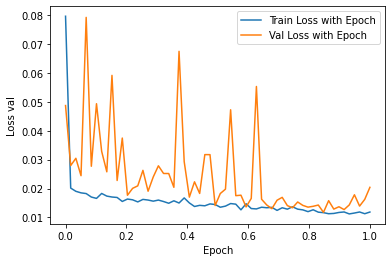

In [117]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

x = np.linspace( 0, 1, len(training_loss_stroe))
ax.plot(x, training_loss_stroe, label='Train Loss with Epoch')
ax.plot(x, val_loss_store ,label='Val Loss with Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss val')
ax.legend()
plt.show()

# Load Model


In [118]:
model = model_utils.load_model(save_dir, 'Double-LSTM-model03')

# Prepare Test Data


In [119]:
data_test = pd.read_csv(processed_data_path + processed_data_files[-1])
input_seqsize = 20
rollout_len_test = 890

window_size_test = input_seqsize + rollout_len_test
data_temp = getConsecutive(data_test, window_size_test, DATA_STRIDE, FEATURE_SIZE)
model_input_test, state = getTestInput(data_temp, window_size_test, constant_)
test_dataset = TestDataset(model_input_test, state, None, input_seqsize, rollout_len_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

Add  (911, 5, 7)  data


RSME -- Acc      : 0.1596835956805268
RSME -- Yaw_rate : 0.03157256260826491
RSME -- Speed    : 0.37232160830632016
RSME -- Yaw      : 0.08930125234919539
RSME -- Position : 8.47313989662322
 


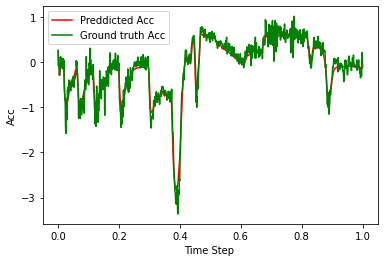

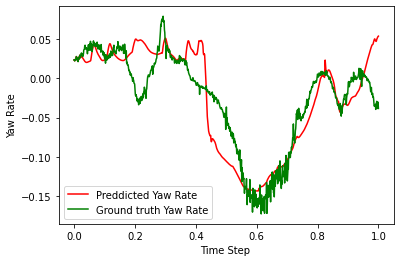

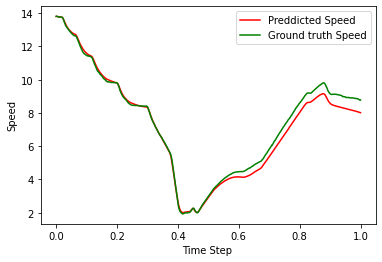

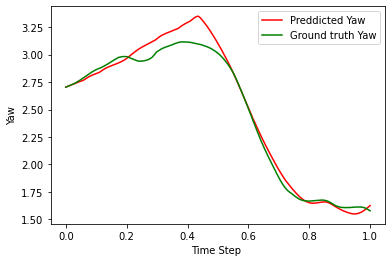

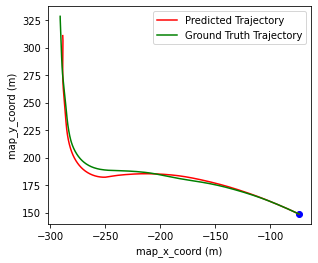

In [120]:
inputseq_len = input_seqsize
rollout_len = rollout_len_test

model.eval()

with torch.no_grad(): 
  for batch_index, data in enumerate(test_dataloader):

      predicted_acc = np.zeros(inputseq_len + rollout_len_test)
      predicted_yaw_rate = np.zeros(inputseq_len + rollout_len_test)

      predicted_speed = np.zeros(inputseq_len + rollout_len_test)
      predicted_yaw = np.zeros(inputseq_len + rollout_len_test)

      predicted_x = np.zeros(inputseq_len + rollout_len_test)
      predicted_y = np.zeros(inputseq_len + rollout_len_test)

      
      model_input, target, cumulated_state, command = data

      dT = cumulated_state[0, :, -1]
      # print(cumulated_state.shape)

      model_input = model_input.float().to(device)
      target = target.float().to(device)
      cumulated_state = cumulated_state.float().to(device)
      command = command.float().to(device)

      predicted_acc[:inputseq_len] = target[0, :inputseq_len, 0].cpu()
      predicted_yaw_rate[:inputseq_len] = target[0, :inputseq_len, 1].cpu()/constant_
      predicted_speed[:inputseq_len] = cumulated_state[0, :inputseq_len, -3].cpu()
      predicted_yaw[:inputseq_len] = cumulated_state[0, :inputseq_len, -2].cpu()
      predicted_x[:inputseq_len] = cumulated_state[0, :inputseq_len, 0].cpu()
      predicted_y[:inputseq_len] = cumulated_state[0, :inputseq_len, 1].cpu()

      for di in range(rollout_len):   
        # print(model_input.shape)  
        model_output = model(model_input)
        
        new_in = torch.cat((command[:, di + inputseq_len, :], model_output), 1)
        new_in = new_in[None, :, :]
        model_input = torch.cat((model_input[:, 1:, :], new_in), 1)

        predicted_acc[inputseq_len + di] = model_output[0, 0]
        predicted_yaw_rate[inputseq_len + di] = model_output[0, 1]/constant_

        # predicted_speed[inputseq_len + di] = predicted_speed[inputseq_len + di - 1] +  target[0, inputseq_len + di - 1, 0].cpu()*dT[inputseq_len + di - 1]
        # predicted_yaw[inputseq_len + di] = predicted_yaw[inputseq_len + di - 1] +   target[0, inputseq_len + di - 1, 1].cpu()/10*dT[inputseq_len + di - 1]

        predicted_speed[inputseq_len + di] = predicted_speed[inputseq_len + di - 1] +  predicted_acc[inputseq_len + di - 1]*dT[inputseq_len + di - 1]
        predicted_yaw[inputseq_len + di] = predicted_yaw[inputseq_len + di - 1] +  predicted_yaw_rate[inputseq_len + di - 1]*dT[inputseq_len + di - 1]

        predicted_x[inputseq_len + di] = predicted_x[inputseq_len + di - 1] +  predicted_speed[inputseq_len + di - 1]*np.cos(predicted_yaw[inputseq_len + di - 1])*dT[inputseq_len + di - 1]
        predicted_y[inputseq_len + di] = predicted_y[inputseq_len + di - 1] +  predicted_speed[inputseq_len + di - 1]*np.sin(predicted_yaw[inputseq_len + di - 1])*dT[inputseq_len + di - 1]
        

      acc_pred = torch.from_numpy(predicted_acc[inputseq_len:])
      yaw_rate_pred = torch.from_numpy(predicted_yaw_rate[inputseq_len:])
      speed_pred = torch.from_numpy(predicted_speed[inputseq_len:])
      yaw_pred = torch.from_numpy(predicted_yaw[inputseq_len:])
      x_pred = torch.from_numpy(predicted_x[inputseq_len:])
      y_pred = torch.from_numpy(predicted_y[inputseq_len:])

      rsme_acc = torch.sqrt(criterion(target[:, inputseq_len:, 0].cpu(), acc_pred.unsqueeze(0)))
      rsme_yaw_rate = torch.sqrt(criterion(target[:, inputseq_len:, 1].cpu()/constant_, yaw_rate_pred.unsqueeze(0)))
      rsme_speed = torch.sqrt(criterion(cumulated_state[:, inputseq_len:, -3].cpu(), speed_pred.unsqueeze(0)))
      rsme_yaw = torch.sqrt(criterion(cumulated_state[:, inputseq_len:, -2].cpu(), yaw_pred.unsqueeze(0)))
      mse_x = criterion(cumulated_state[:, inputseq_len:, 0].cpu(), x_pred.unsqueeze(0))
      mse_y = criterion(cumulated_state[:, inputseq_len:, 1].cpu(), y_pred.unsqueeze(0))
      rsme_position = torch.sqrt(mse_x + mse_y)

      print(f"RSME -- Acc      : {rsme_acc}")
      print(f"RSME -- Yaw_rate : {rsme_yaw_rate}")
      print(f"RSME -- Speed    : {rsme_speed}")
      print(f"RSME -- Yaw      : {rsme_yaw}")
      print(f"RSME -- Position : {rsme_position}")
      print(' ')  

      visualize_result_state(predicted_acc, target[0, :, 0].cpu(), "Acc")
      visualize_result_state(predicted_yaw_rate, target[0, :, 1].cpu()/constant_, "Yaw Rate")
      visualize_result_state(predicted_speed, cumulated_state[0, :, 2].cpu(), "Speed")
      visualize_result_state(predicted_yaw, cumulated_state[0, :, 3].cpu(), "Yaw")
      visualize_result_position(predicted_x, predicted_y, cumulated_state[0, :, 0].cpu(), cumulated_state[0, :, 1].cpu())

      break